In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, RobustScaler

with open('../data/DatasetCleaned.csv', 'r') as f:
    data = pd.read_csv(f)


Y_DATA = np.log(data['SalePrice'].copy()).values
VAR_DEPENDENT = 'SalePrice_log'


X_DATA = data.copy().drop(columns=['SalePrice','Unnamed: 0'])

def PrepX(X:pd.DataFrame=X_DATA, scaler=PowerTransformer(method='yeo-johnson')):

    X_prep = pd.DataFrame(index=X.index)
    X_types = X.dtypes.to_dict()

    cat_cols = []
    for col, t in X_types.items():

        #Handles dummy columns and Percentages that don't need to be scaled computed in Preperation
        if t != 'object' and -1 <= X[col].min() and X[col].max() <= 1: 
            X_prep[col] = X[col].copy().replace({-1:0})
            continue

        if t == 'object': 
            new_col = pd.get_dummies(X[col].copy(), prefix=col, drop_first=True, dtype=int)
            cat_cols.append(new_col)
            continue

        if t in ['int', 'float']:
            nonapplicable = X[col] == -1

            new_col = X[col].copy()
            applic_values = new_col.loc[~nonapplicable].values.reshape(-1, 1)
            new_col.loc[~nonapplicable] = scaler.fit_transform(applic_values).flatten()
            new_col.loc[nonapplicable] = 0

            X_prep[col] = new_col
            
            continue

        print(f'Type \"{t}\" not in standard types!')

    if cat_cols: X_prep = pd.concat([X_prep] + cat_cols, axis=1)

    var_names = X_prep.columns
    X_prep = X_prep.values.reshape(-1, X_prep.shape[1])

    return X_prep, var_names

X_DATA, VAR_NAMES = PrepX()

C:\Users\karli\AppData\Local\Temp\ipykernel_20124\3833608487.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.14545181  0.09841449  0.40342175 ... -1.70419946  3.88329402
 -0.37218074]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_col.loc[~nonapplicable] = scaler.fit_transform(applic_values).flatten()
C:\Users\karli\AppData\Local\Temp\ipykernel_20124\3833608487.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.677626   -0.03607174  0.677626   ... -0.03607174  2.67851644
 -0.78029271]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_col.loc[~nonapplicable] = scaler.fit_transform(applic_values).flatten()
C:\Users\karli\AppData\Local\Temp\ipykernel_20124\3833608487.py:38: FutureWarning: Setting an item of incompatible d

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold, cross_val_score

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

def RegrLasso(Y, X, dependent_var:str, feature_names:list, alpha, #Function imported from another project of mine, see https://github.com/Interorm/IMF-Bias---Hausarbeit
              display:bool=True, iter:int=100000):

    if display:
        coefs_all = [] 
        mse = []
        for a in tqdm(alpha): 
            lasso = Lasso(alpha=a,  max_iter=1000000, tol=1e-4)
            lasso.fit(X, Y) 
            coefs_all.append(lasso.coef_) 
            mse_this = ( -cross_val_score(lasso, X, Y, scoring="neg_mean_squared_error", cv=KFold()) )
            mse_this = np.mean(mse_this)
            mse.append(mse_this)
        coefs_all = np.array(coefs_all)
    

    lasso_cv = LassoCV(alphas=alpha, cv=KFold(), max_iter=100000)
    lasso_cv.fit(X, Y)

    best_alpha = lasso_cv.alpha_
    print("Best alpha:", best_alpha)

    
    print(f"R²: {lasso_cv.score(X,Y)}")

    coefs = []
    for i, featuer in enumerate(feature_names):
        coef = lasso_cv.coef_[i]
        if coef == 0: continue
        coefs.append({"Regressor": featuer, "Coefficient": coef})
    coefs = sorted(coefs, key = lambda x: x["Coefficient"], reverse=True)
    for coef in coefs: 
        c = round(coef["Coefficient"], 4)
        r = coef["Regressor"]
        if any(True for fixed in ["Region", "Country"] if fixed in r): continue
        print(f"{r}: {c}")

    if display: 
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,16))
        
        # Top Left axis: MSE
        ax1.plot(alpha, mse, color="red", linewidth=2, label="CV MSE")
        ax1.set_xlabel("Lambda")
        ax1.set_xscale("log")
        ax1.set_ylabel("Mean Squared Error")
        ax1.set_title('Mean Squared Error')
        ax1.axvline(x = best_alpha, color = 'black', linestyle = '--')
        #ax1.tick_params(axis="y", labelcolor="red")

        # Top Right axis: Coefficients
        colors = sns.color_palette("Paired", len(feature_names))
        for i, name in enumerate(feature_names):
            if any(True for fixed in ["Region", "Country"] if fixed in name): continue
            ax2.plot(alpha, coefs_all[:, i], label=name, color=colors[i])
        ax2.set_xlabel("Lambda")
        ax2.set_xscale("log")
        ax2.set_ylabel("Coefficient values")
        ax2.set_title("Lasso Coefficients vs Lambda")
        ax2.axvline(x = best_alpha, color = 'black', linestyle = '--')
        ax2.grid(True)

        # Bottom Left: Predcition vs. Truth
        Y_predicted = pd.DataFrame({'Predicted':lasso_cv.predict(X), 'True':Y})
        Y_predicted = Y_predicted.sort_values(by='True')
        ax3.plot( Y_predicted['True'], Y_predicted['Predicted'], color='lightblue', label='Predicted Values' )
        ax3.plot( Y_predicted['True'], Y_predicted['True'], color = 'red' )
        ax3.set_xlabel(f'Actual {dependent_var}')
        ax3.set_ylabel(f'Predicted {dependent_var}')
        ax3.set_title('Prediction vs. Reality for Best Model')
        ax3.grid(False)

        # Bottom Right: Number of relevant Coef
        ax4.plot(alpha, np.count_nonzero(coefs_all, axis=1), color='red', label = 'Non-Zero Coefficients')
        ax4.set_xlabel("Lambda")
        ax4.set_xscale("log")
        ax4.set_ylabel("# Non-Zero Coefficients")
        ax4.set_title("Non-Zero Coefficients")
        ax4.axvline(x = best_alpha, color = 'black', linestyle = '--')
        ax4.grid(True)


        plt.tight_layout()
        plt.show()

    return lasso_cv


  0%|          | 0/500 [00:00<?, ?it/s]

Best alpha: 0.000634753655204233
R²: 0.915816219784639
Has_Basement: 0.1374
Neighborhood_StoneBr: 0.1221
Neighborhood_Crawfor: 0.1001
Neighborhood_Somerst: 0.0886
OverallQual: 0.0881
1stFlrSF: 0.0812
MSSubClass_1-1/2 STORY FINISHED ALL AGES: 0.078
Neighborhood_NoRidge: 0.0757
Has_Garage: 0.072
Neighborhood_NridgHt: 0.0657
HouseStyle_2Story: 0.0653
SaleCondition_Normal: 0.0588
Condition1_Norm: 0.0536
SaleType_New: 0.0524
Exterior1st_BrkFace: 0.0495
OverallCond: 0.0462
Neighborhood_ClearCr: 0.0444
Has_Fireplace: 0.0428
2ndFlrSF: 0.042
Neighborhood_BrkSide: 0.0417
LotArea: 0.041
Bathrooms: 0.0398
CentralAir: 0.0388
MSZoning_RL: 0.0367
MSSubClass_2-1/2 STORY ALL AGES: 0.0325
BsmtFinish_GLQ: 0.0307
TotRmsAbvGrd: 0.0297
GarageCars: 0.0241
Sold_12-2007: 0.0221
Sold_07-2007: 0.0212
Sold_07-2009: 0.0206
GarageFinish: 0.0198
LandSlope_Mod: 0.0179
TotalBsmtSF: 0.0172
BsmtBathrooms: 0.017
Foundation_PConc: 0.0153
HeatingQC: 0.0133
BsmtQual: 0.0133
WoodDeckSF: 0.0129
FireplaceQu: 0.0112
Sold_07-200

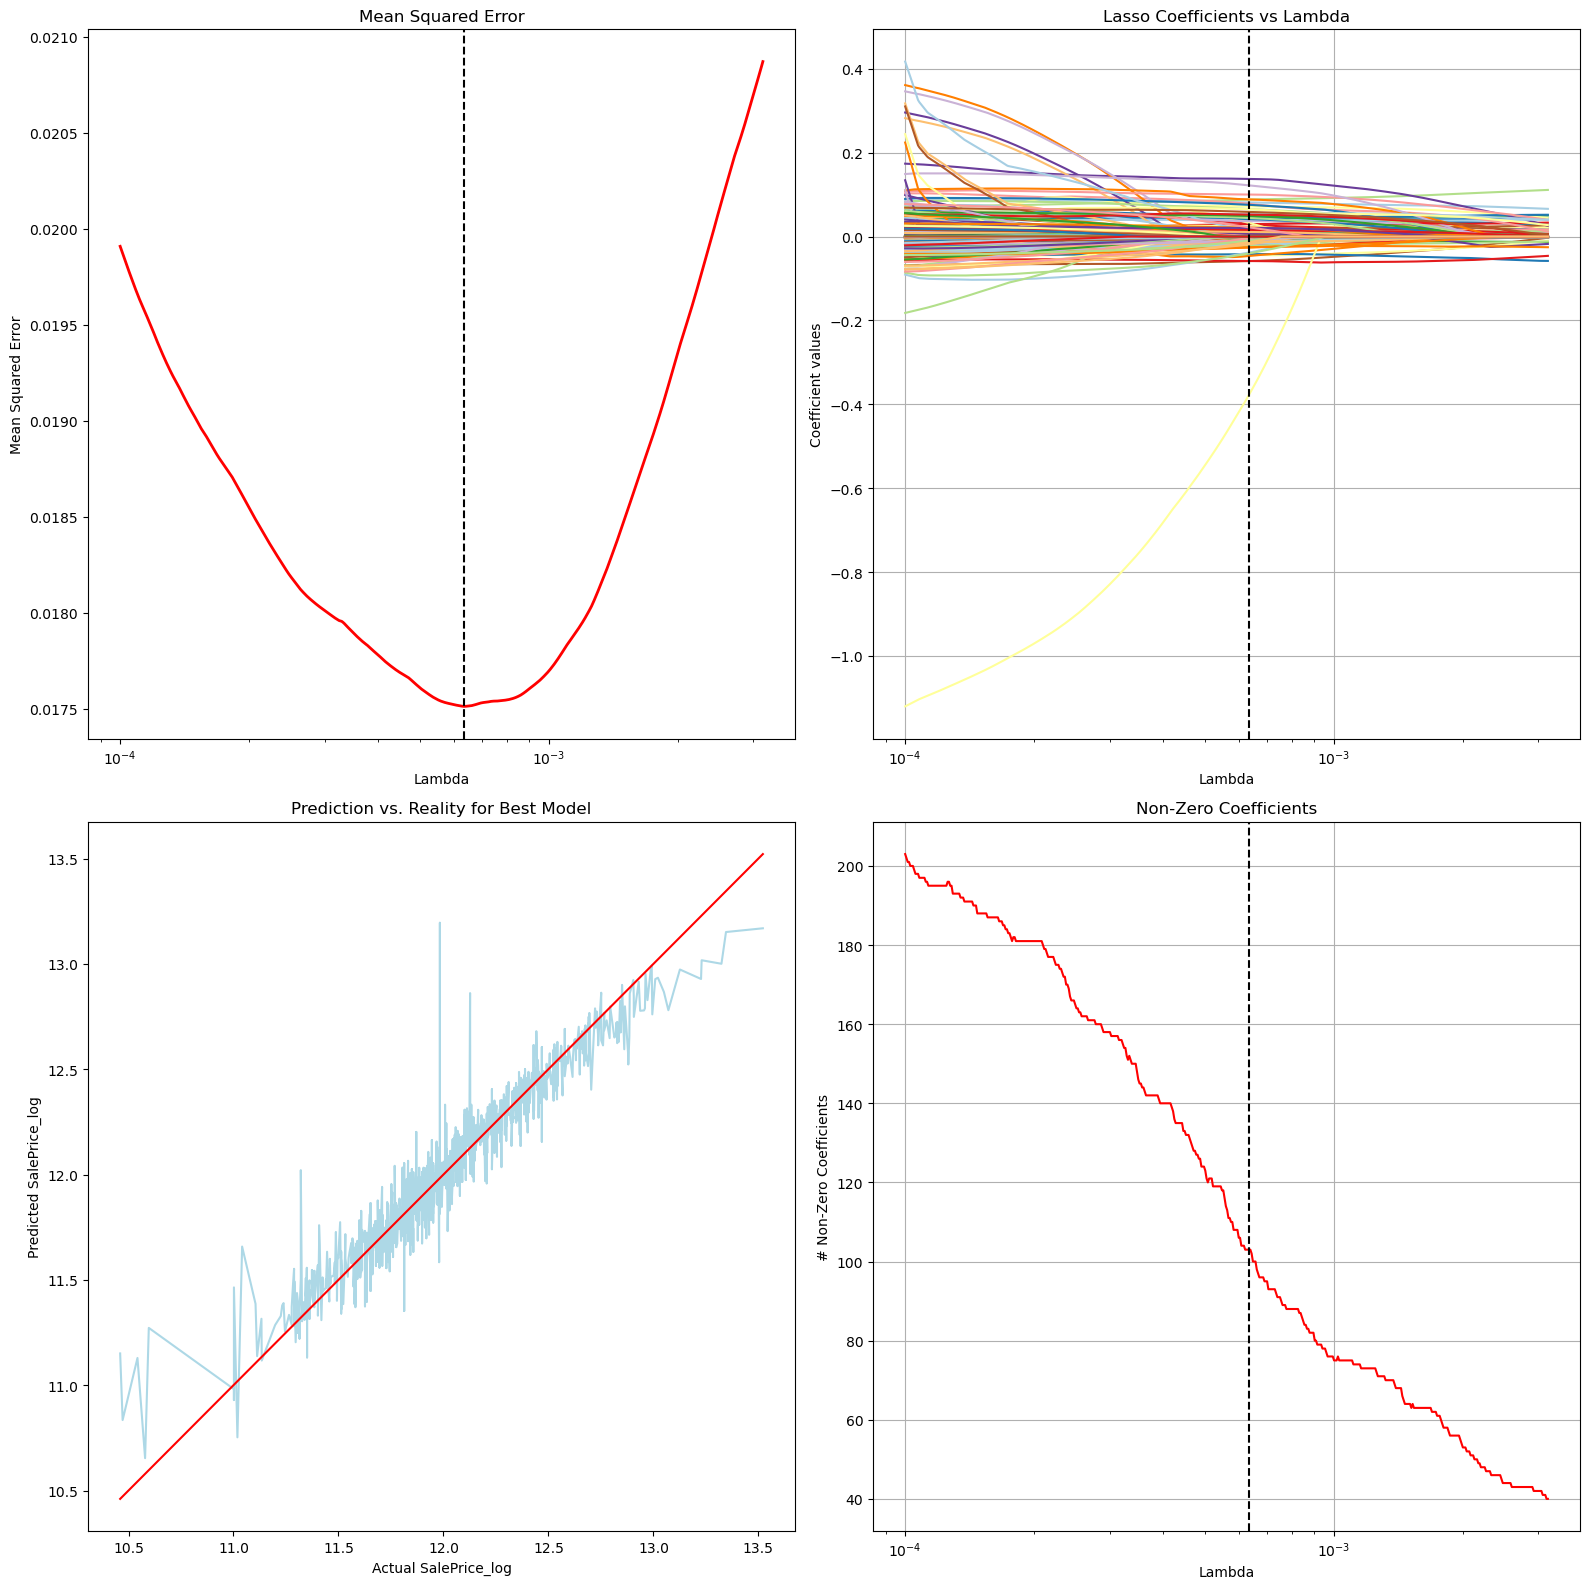

In [11]:
lasso_model = RegrLasso(Y_DATA, X_DATA, VAR_DEPENDENT, VAR_NAMES,  alpha=np.logspace(-4,-2.5,500))

In [4]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_score

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

def BootstrapLasso(Y, X, feature_names:list, alpha, n_bootstrap, display:bool=True):

    n_obs = len(Y)

    B = []
    FailedReg = 0
    for i in tqdm(range(0, n_bootstrap),
                  desc='Fitting Lasso-Model with Bootstrapped Samples', unit='sample'):
        sample_index = np.random.choice(range(0, n_obs), n_obs)

        X_sample = X[sample_index]
        Y_sample = Y[sample_index]

        lasso = LassoCV(alphas=alpha, cv=KFold(), max_iter=100000)
        lasso.fit(X_sample, Y_sample)        

        if lasso.alpha_ == min(alpha): 
            FailedReg += 1
            continue

        coefs = {}
        for i, var in enumerate(feature_names):
            coefs[var] = lasso.coef_[i]

        mse = np.mean((Y - lasso.predict(X))**2)

        B.append({
            'X_sample':X_sample,
            'Y_sample':Y_sample,
            'Sample_Key':sample_index,
            'LassoModel':lasso,
            'alpha':lasso.alpha_,
            'r_squared':lasso.score(X_sample, Y_sample),
            'r_squared_fullData':lasso.score(X, Y),
            'coefficients':coefs,
            'mse':mse,
            'N Nonzero Estimators':sum([1 for key, item in coefs.items() if item != 0])
        })


    print(f'{FailedReg} failed regularizations')
    return pd.DataFrame(B)

In [14]:
#This takes about 30 Minutes to run
#BootstrappedModels = BootstrapLasso(Y_DATA, X_DATA, VAR_NAMES, alpha=np.logspace(-4,-2,200), n_bootstrap=1000)

import pickle

with open('../models/Bootstrapped_Lasso.sav', 'rb') as f: BootstrappedModels = pickle.load(f)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def Coefficient_Boxplots(B_Coefficients:pd.Series, Lasso_Orig:LassoCV, var_names:list, cutoff:int=0.0):

    relevant_cols = []
    for i, var in enumerate(var_names):
        values = np.array([B[var] for B in B_Coefficients])
        if np.count_nonzero(values) / len(values) >= cutoff:
            relevant_cols.append({'var':var, 'coefs':values, 'index':i})
    
    boxplot_rows = int(np.ceil(len(relevant_cols) / 5))
    fig, axes = plt.subplots(boxplot_rows, 5, figsize=(15, 2*boxplot_rows))
    axes = axes.flatten()

    for ax, var in zip(axes, relevant_cols):
        ax.boxplot(var['coefs'], patch_artist=True)
        ax.axhline(y = 0, color='black', ls = '--')
        ax.axhline(y = Lasso_Orig.coef_[var['index']], color = 'red', ls=':')
        ax.set_title(var['var'], fontsize=8)

    plt.show()


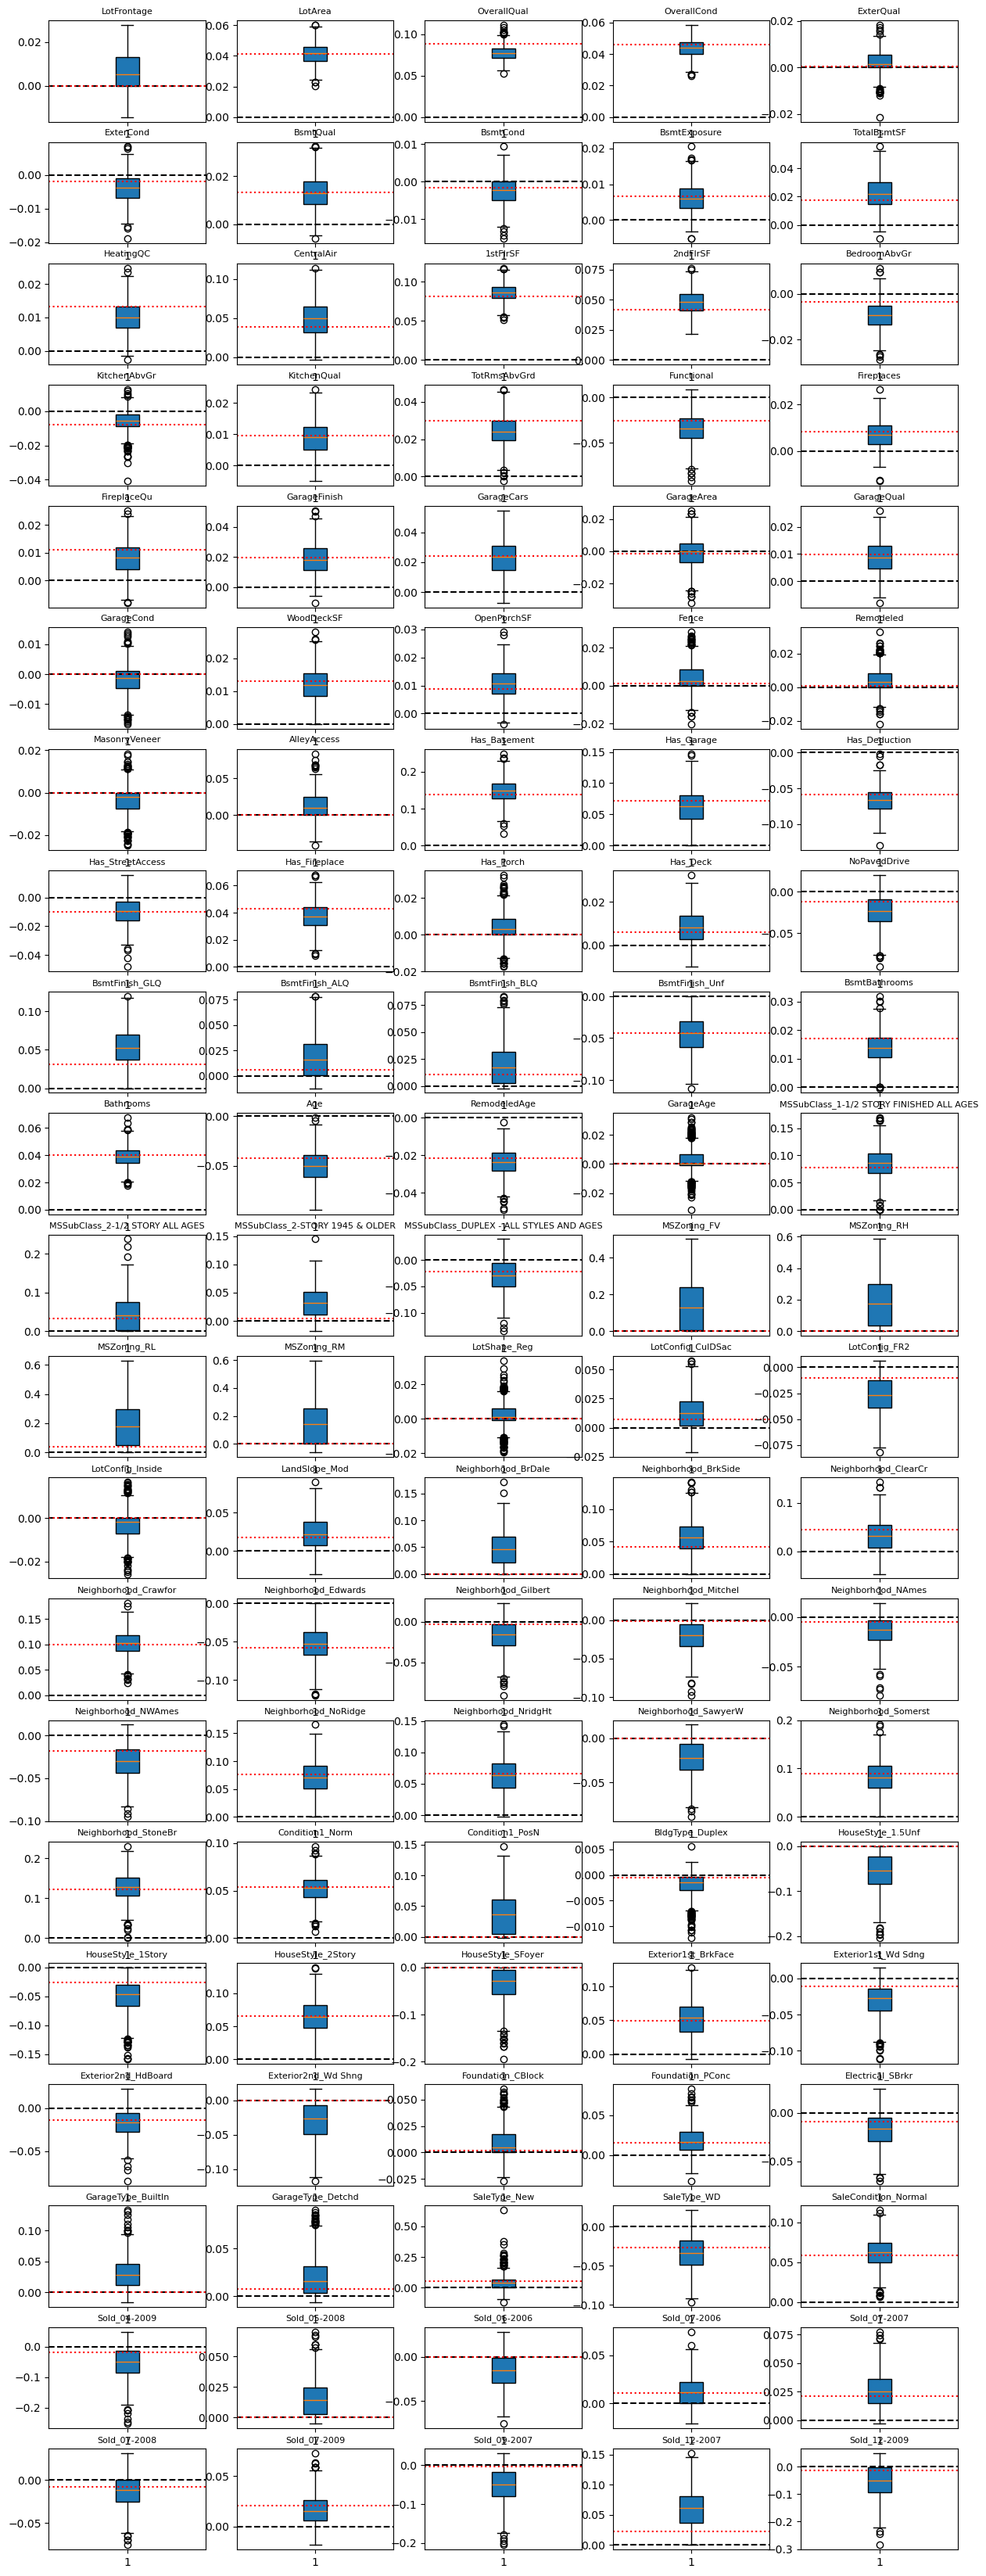

In [15]:
Coefficient_Boxplots(BootstrappedModels['coefficients'], lasso_model, VAR_NAMES, 0.75)